# SETUP NOTEBOOK

## DO NOT FORGET TO RUN THESE TWO CELLS BELOW



In [4]:
#@title <<<<<<<<<<<<< RUN ME FIRST
import os 
branch_name = "master" #@param {type:"string"}
os.environ['BRANCH_NAME'] = branch_name
os.environ['GH_TOKEN'] = ''

!rm -rf *
!git clone -b $BRANCH_NAME https://github.com/Chilefase/Tradespace.git
!cp -r Tradespace/* ./
!rm -rf Tradespace
!pip install numpy pandas pandas_bokeh
!echo "Notebook is setup!!"

Cloning into 'Tradespace'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 4), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (17/17), done.
Notebook is setup!!


In [5]:
from google.colab import files
from itertools import product

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pandas_bokeh # DOCS: https://patrikhlobil.github.io/Pandas-Bokeh/
import seaborn as sns

from models.autonomous_system import AutonomousSystemChoice
from models.battery_charger import BatteryChargerChoice
from models.battery_pack import BatteryPackChoice
from models.chasis import ChasisChoice
from models.ev import Ev
from models.fleet import Fleet
from models.motor_and_inverter import MotorAndInverterChoice
from models.multi_attribute_utility import MultiAttributeUtility
from models.route import Route

pandas_bokeh.output_notebook()

# Task 1

In [6]:

case_a = MultiAttributeUtility(
    name = "CASE A",
    daily_passenger_volume = 1000,
    peak_passenger_throuput = 75,
    average_wait_time_minutes = 8,
    availability = 0.7
)

case_b = MultiAttributeUtility(
    name = "CASE B",
    daily_passenger_volume = 2000,
    peak_passenger_throuput = 100,
    average_wait_time_minutes = 12,
    availability = 0.6
)

case_c = MultiAttributeUtility(
    name = "CASE C",
    daily_passenger_volume = 750,
    peak_passenger_throuput = 75,
    average_wait_time_minutes = 6,
    availability = 0.8
)

print(case_a)
print(case_b)
print(case_c)

********************
CASE NAME:             CASE A
PASSENGER VOLUME:        1000
PASSENGER THROUGHPUT:      75
AVERAGE WAIT TIME:          8
AVAILABILITY:             0.7
MAU:                    0.613

********************
CASE NAME:             CASE B
PASSENGER VOLUME:        2000
PASSENGER THROUGHPUT:     100
AVERAGE WAIT TIME:         12
AVAILABILITY:             0.6
MAU:                   0.6385

********************
CASE NAME:             CASE C
PASSENGER VOLUME:         750
PASSENGER THROUGHPUT:      75
AVERAGE WAIT TIME:          6
AVAILABILITY:             0.8
MAU:                    0.651



# **FUNCTIONS**

In [7]:
def calculate_frequency(peak_throughput_target, load_factor, capacity):
  f = peak_throughput_target / (load_factor * capacity)
  return math.ceil(f)


def generate_fleet_combinations(route_length, route_stops, calc_fleet_size):  
  # create route
  route = Route(route_length, route_stops)
  choices = (list(x) for x in (AutonomousSystemChoice, BatteryChargerChoice, BatteryPackChoice, ChasisChoice, MotorAndInverterChoice))
  for autonomy, bcharger, bpack, chasis, motor in product(*choices):
    # Change by Yousif: The end value of range is changed from 15 to
    # calc_fleet_size + 1
    for fleet_size in range(1, calc_fleet_size + 1, 1):
        try:
            # create car
            ev = Ev(
                autonomous_system_choice=autonomy,
                battery_charger_choice=bcharger,
                battery_pack_choice=bpack,
                chasis_choice=chasis,
                motor_and_inverter_choice=motor,
                violate_constraints=False
            )

            # create fleet
            fleet = Fleet(ev=ev, route=route, fleet_size=fleet_size)
        except ValueError as e:
            continue
        
        yield fleet


def fix_category_dtypes(dataframe):
  type_mapping = {
    'autonomous_system': {
        'type': 'category',
        'prefix': 'A',
        'count': 5
    },
    'battery_pack': {
        'type': 'category',
        'prefix': 'P',
        'count': 6
    },
    'battery_charger': {
        'type': 'category',
        'prefix': 'G',
        'count': 3
    },
    'chasis': {
        'type': 'category',
        'prefix': 'C',
        'count': 8
    },
    'motor_and_inverter':{
        'type': 'category',
        'prefix': 'M',
        'count': 4
    }
  }

  for col, mapping in type_mapping.items():
      dataframe[col] = dataframe[col].astype(mapping['type'])
      cats = [f'{mapping["prefix"]}{n}' for n in range(1, mapping['count']+1)]
      dataframe[col].cat.reorder_categories(new_categories=cats, ordered = True, inplace = True)

  return dataframe

# **USE CASE 1**

In [8]:
#@title Generator Params { display-mode: "both" }
route_length_in_km = 5.4#@param {type:"number"}
number_of_stops_on_route = 13#@param {type:"number"}
peak_throughput_target = 150

# Traffic time constant measured by Google for specific route.
# It is defined as no traffic time * 1.5 factor to account 
# for minor traffic variations
traffic_time_constant = 15#@param {type:"number"}

# Specified speed limit in Cambridge is 20 MPH or 32km/hr
rate = 32#@param
if rate == False:
  rate = 32
dwell_time_minutes = 1 


###
# Changes below by Yousif - Testing generation of fleet size using
# the peakthroughput target to get use cases to affect the tradespace
###
load_factor = 0.75
capacity = 15

frequency = calculate_frequency(peak_throughput_target, load_factor, capacity)
print('Frequency:', frequency)
round_trip_time_per_car = (60*route_length_in_km/rate) + (dwell_time_minutes * number_of_stops_on_route + traffic_time_constant)
print('round_trip_time_per_car:', round_trip_time_per_car)
trips_per_car_per_hour = 60 / round_trip_time_per_car
print('trips_per_car_per_hour:', trips_per_car_per_hour)
fleet_size = math.ceil(peak_throughput_target / (trips_per_car_per_hour * capacity * load_factor))
print('fleet_size:', fleet_size)

# new param added to generate_fleet_combinations: fleet_size
df = pd.DataFrame((f.to_dict() for f in generate_fleet_combinations(route_length_in_km, number_of_stops_on_route, fleet_size)))
df = fix_category_dtypes(df)
print(f'Done generating dataframe of size: {len(df)}')

Frequency: 14
round_trip_time_per_car: 38.125
trips_per_car_per_hour: 1.5737704918032787
fleet_size: 9
Done generating dataframe of size: 12420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

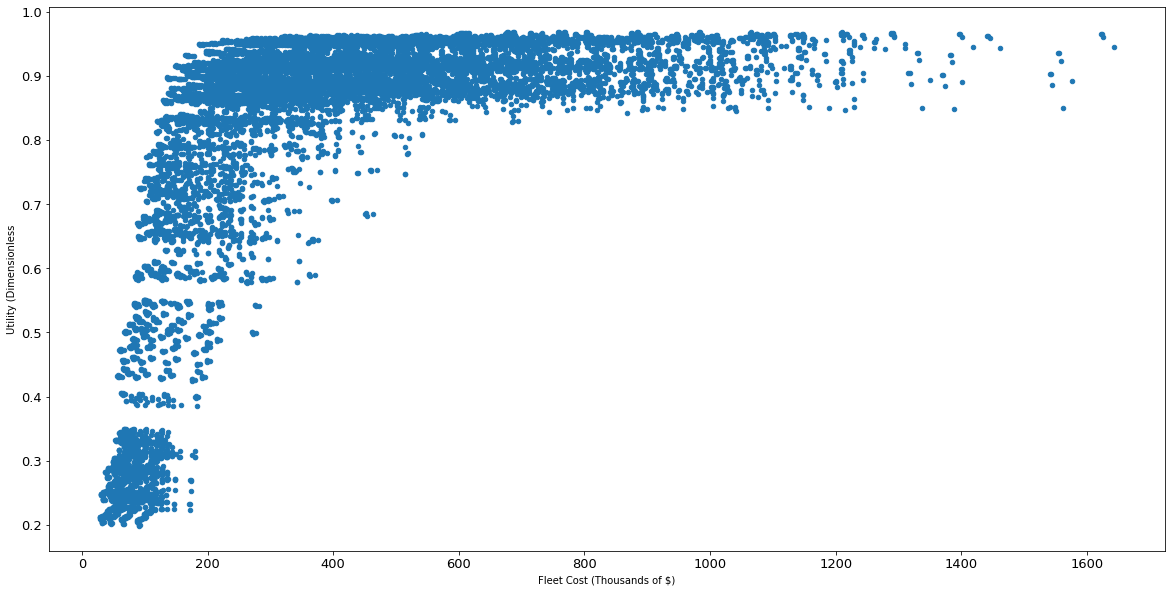

In [9]:
filter = "fleet_cost_1k_usd"
df.plot(kind='scatter', x=filter, y='score', figsize=(20, 10), xlabel = 'Fleet Cost (Thousands of $)', ylabel = 'Utility (Dimensionless', fontsize = 13)

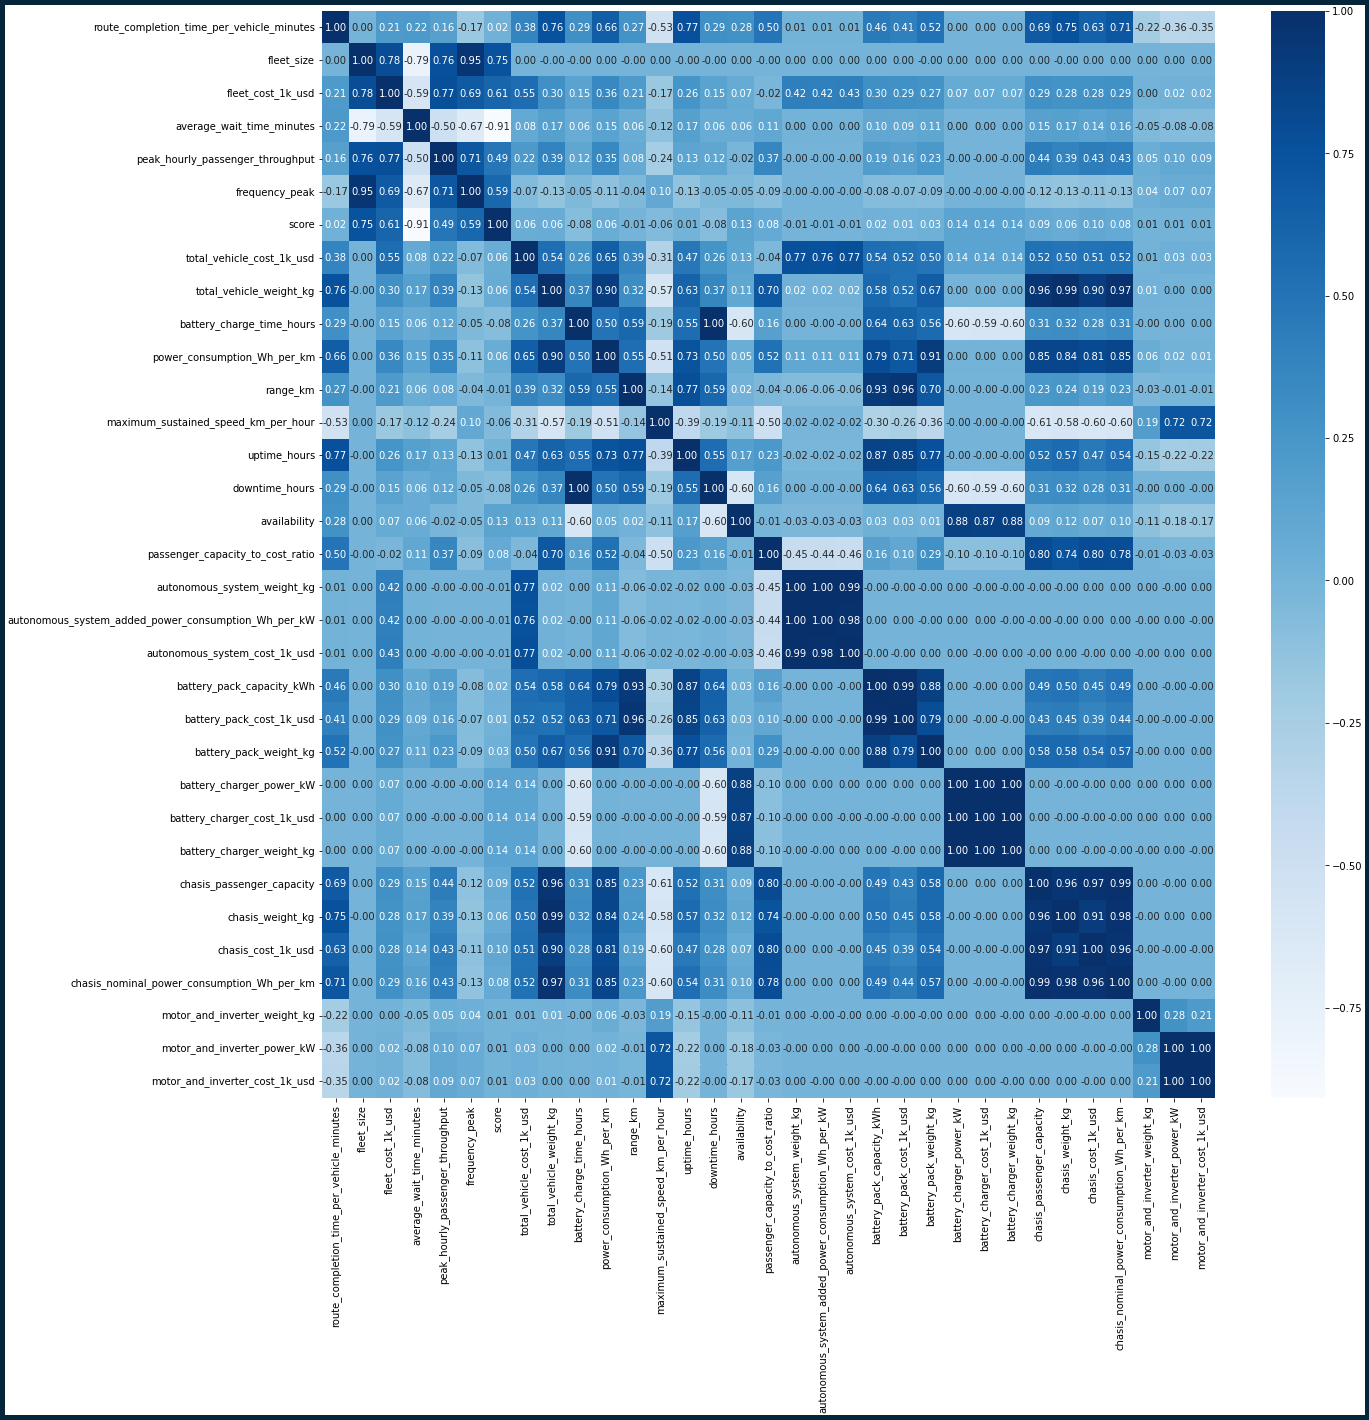

In [ ]:
labels_to_drop = ['MAX_SPEED_KMH','operated_speed_km_hour', 'peak_throughput_target', 'maximum_passenger_volume', 'length_km', 'stops'] 
filtered = df.drop(columns=labels_to_drop)
plt.figure(figsize=(20,20),linewidth=10, edgecolor="#04253a")
sns.heatmap(filtered.corr(), annot=True, cmap=plt.cm.Blues, fmt='.2f')
plt.show()

# Generate the design space

In [ ]:
#@title
# By autonomy levels:

colors = ['#deebf7','#9ecae1','#3182bd']

filter = "fleet_cost_1k_usd"

# hts  = 'Utility: @score </br>'
# hts += 'Fleet Cost: @fleet_cost_1k_usd </br>'
hts = 'Fleet Size: @fleet_size </br>'
# hts += 'Availability: @availability </br>'
hts += 'Autonomy: @autonomous_system </br>'
hts += 'Battery Charger: @battery_charger </br>'
hts += 'Battery Pack: @battery_pack </br>'
hts += 'Chasis: @chasis </br>'
hts += 'Motor: @motor_and_inverter </br>'
# hts += 'Wait Time: @average_wait_time_minutes minutes </br>'
# hts += 'Maximum Daily Volume: @maximum_passenger_volume </br>'
# hts += 'Vehicle Capacity: @chasis_passenger_capacity </br>'

filtered_df = df[df['autonomous_system'] >= 'A3']
filtered_df.plot_bokeh.scatter( hatch_scale = 1, figsize=(1200, 750), x=filter, y='score', category='autonomous_system', hovertool_string=hts, colormap=colors, xlabel = 'Fleet Cost (Thousands of $)', ylabel = 'Utility (Dimensionless)')


Figure(id='1002', ...)

In [ ]:
# EXPORT USE CASE 1 AS CSV HERE
df.to_csv('usecase_1.csv') 
files.download('usecase_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **USE CASE 2**

In [ ]:
#### USE CASE 2 ####

#@title Generator Params { display-mode: "both" }
route_length_in_km =  2.55#@param {type:"number"}
number_of_stops_on_route =  10#@param {type:"number"}
peak_throughput_target = 150

# Traffic time constant measured by Google for specific route.
# It is defined as no traffic time * 1.5 factor to account 
# for minor traffic variations
traffic_time_constant = 7.5#@param {type:"number"}

# Specified speed limit in Cambridge is 20 MPH or 32km/hr
rate = 15#@param
# 15 km/hr assumed inside MIT to account for heavy traffic
# movement, subject to MIT approval.
if rate == False:
  rate = 32
dwell_time_minutes = 1 

###
# Changes below by Yousif - Testing generation of fleet size using
# the peakthroughput target to get use cases to affect the tradespace
###
load_factor = 0.75
capacity = 15

frequency = calculate_frequency(peak_throughput_target, load_factor, capacity)
print('Frequency:', frequency)
round_trip_time_per_car = (60*route_length_in_km/rate) + (dwell_time_minutes * number_of_stops_on_route + traffic_time_constant)
print('round_trip_time_per_car:', round_trip_time_per_car)
trips_per_car_per_hour = 60 / round_trip_time_per_car
print('trips_per_car_per_hour:', trips_per_car_per_hour)
fleet_size = math.ceil(peak_throughput_target / (trips_per_car_per_hour * capacity * load_factor))
print('fleet_size:', fleet_size)

# new param added to generate_fleet_combinations: fleet_size
df = pd.DataFrame((f.to_dict() for f in generate_fleet_combinations(route_length_in_km, number_of_stops_on_route, fleet_size)))
df = fix_category_dtypes(df)
print(f'Done generating dataframe of size: {len(df)}')

Frequency: 14
round_trip_time_per_car: 27.7
trips_per_car_per_hour: 2.1660649819494586
fleet_size: 7
Done generating dataframe of size: 9660


In [ ]:
df.describe()

,route_completion_time_per_vehicle_minutes,fleet_size,fleet_cost_1k_usd,average_wait_time_minutes,peak_hourly_passenger_throughput,maximum_passenger_volume,frequency_peak,score,length_km,stops,MAX_SPEED_KMH,total_vehicle_cost_1k_usd,total_vehicle_weight_kg,battery_charge_time_hours,power_consumption_Wh_per_km,range_km,maximum_sustained_speed_km_per_hour,operated_speed_km_hour,uptime_hours,downtime_hours,availability,passenger_capacity_to_cost_ratio,autonomous_system_weight_kg,autonomous_system_added_power_consumption_Wh_per_kW,autonomous_system_cost_1k_usd,battery_pack_capacity_kWh,battery_pack_cost_1k_usd,battery_pack_weight_kg,battery_charger_power_kW,battery_charger_cost_1k_usd,battery_charger_weight_kg,chasis_passenger_capacity,chasis_weight_kg,chasis_cost_1k_usd,chasis_nominal_power_consumption_Wh_per_km,motor_and_inverter_weight_kg,motor_and_inverter_power_kW,motor_and_inverter_cost_1k_usd
count,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9.660000e+03,9660.0,9660.0,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.00000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.000000,9660.00000,9660.000000,9660.000000
mean,16.140567,4.000000,319.380435,5.978689,893.850414,15732.391140,75.347442,0.823551,2.550000e+00,10.0,32.0,79.845109,4471.717391,3.985512,253.836957,271.612034,47.717455,27.634238,11.320766,4.235512,0.734297,0.209719,45.400000,2.10000,22.600000,71.739130,17.130435,652.130435,30.000000,4.500000,2.600000,16.608696,3676.086957,33.652174,172.173913,95.50000,240.000000,1.962500
std,2.429403,2.000104,205.803257,4.668747,945.717654,17018.252396,62.899942,0.186019,4.427799e-13,0.0,0.0,29.027035,2326.087676,3.710159,52.829419,97.017442,33.995249,7.025582,8.160012,3.710159,0.124537,0.109796,41.866711,1.59382,22.367203,42.597589,11.149000,329.653135,21.603587,3.937208,1.728287,9.590977,2119.270192,10.524260,26.037530,29.34006,123.699572,0.958809
min,14.781000,1.000000,28.200000,2.112000,4.000000,56.131200,2.533300,0.298900,2.550000e+00,10.0,32.0,28.200000,1836.000000,0.666700,184.100000,136.658700,11.815000,11.815000,4.329800,0.916700,0.432900,0.019700,5.000000,0.50000,1.000000,40.000000,8.000000,420.000000,10.000000,1.000000,1.000000,2.000000,1350.000000,12.000000,135.000000,60.00000,150.000000,1.200000
25%,14.781000,2.000000,155.100000,2.956000,194.000000,3007.300200,16.166700,0.843075,2.550000e+00,10.0,32.0,58.100000,2585.000000,1.250000,213.270000,191.094950,22.701725,22.701725,6.647950,1.500000,0.616675,0.125675,12.000000,1.00000,2.000000,40.000000,8.000000,420.000000,10.000000,1.000000,1.000000,8.000000,2000.000000,29.000000,150.000000,76.50000,150.000000,1.350000
50%,14.781000,4.000000,278.700000,3.757500,538.500000,9274.474800,64.833300,0.897700,2.550000e+00,10.0,32.0,75.625000,3414.900000,3.000000,239.540000,270.660400,39.713600,32.000000,9.106300,3.250000,0.728950,0.198450,30.000000,1.50000,15.000000,60.000000,16.000000,512.000000,20.000000,2.500000,1.800000,16.000000,2500.000000,33.000000,165.000000,91.00000,180.000000,1.525000
75%,16.739250,6.000000,441.600000,7.391000,1344.000000,23533.934400,128.288925,0.932325,2.550000e+00,10.0,32.0,100.450000,7520.750000,6.000000,276.300000,311.119475,56.546150,32.000000,11.851500,6.250000,0.860075,0.288450,60.000000,2.50000,35.000000,75.000000,16.000000,800.000000,60.000000,10.000000,5.000000,30.000000,7000.000000,47.000000,210.000000,110.00000,270.000000,2.137500
max,22.950000,7.000000,1278.200000,22.950000,4461.000000,91068.638400,198.866700,0.971900,2.550000e+00,10.0,32.0,182.600000,8945.000000,24.000000,409.500000,623.214700,167.910400,32.000000,51.910800,24.250000,0.929600,0.515500,120.000000,5.00000,60.000000,240.000000,62.000000,1680.000000,60.000000,10.000000,5.000000,30.000000,7000.000000,47.000000,210.000000,140.00000,450.000000,3.600000


In [ ]:
#@title
# By autonomy levels:

colors = ['#deebf7','#9ecae1','#3182bd']

filter = "fleet_cost_1k_usd"

hts2  = 'Utility: @score </br>'
hts2 += 'Fleet Cost: @fleet_cost_1k_usd </br>'
hts2 += 'Fleet Size: @fleet_size </br>'
# hts2 += 'Availability: @availability </br>'
hts2 += 'Autonomy: @autonomous_system </br>'
hts2 += 'Battery Charger: @battery_charger </br>'
hts2 += 'Battery Pack: @battery_pack </br>'
hts2 += 'Chasis: @chasis </br>'
hts2 += 'Motor: @motor_and_inverter </br>'
# hts2 += 'Wait Time: @average_wait_time_minutes minutes </br>'
# hts2 += 'Maximum Daily Volume: @maximum_passenger_volume </br>'
# hts2 += 'Vehicle Capacity: @chasis_passenger_capacity </br> '

filtered_df = df[df['autonomous_system'] >= 'A3']
filtered_df.plot_bokeh.scatter( hatch_scale = 1, figsize=(1200, 750), x=filter, y='score', category='autonomous_system', hovertool_string=hts, colormap=colors, xlabel = 'Fleet Cost (Thousands of $)', ylabel = 'Utility (Dimensionless)')

Figure(id='1187', ...)

In [ ]:
# EXPORT USE CASE 2 AS CSV HERE
df.to_csv('usecase_2.csv') 
files.download('usecase_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>